In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-kannada/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-kannada/classification')

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,headline,label
0,"CWG18; ಕುಸ್ತಿಯಲ್ಲಿ ಚಿನ್ನಗಳಿಸಿದ ರಾಹುಲ್ ಅವಾರೆ, ಸ...",sports
1,ಏಷ್ಯಾ ಕಪ್ 2018: ಪಾಕ್ ವಿರುದ್ಧ ಘರ್ಜಿಸಲು ರೋಹಿತ್ ಸ...,sports
2,ಸಮಂತಾ ವಿಷಯದಲ್ಲಿ 'ಯೂ ಟರ್ನ್'​ ಹೊಡೆದ ನಾಗ ಚೈತನ್ಯ..!,entertainment
3,PHOTOS: ಐಶ್ ಬೇಬಿ ಸೌಂದರ್ಯದ ಗುಟ್ಟು ರಟ್ಟು: 40 ದಾಟ...,entertainment
4,ಟೀಂ ಇಂಡಿಯಾ ಆಯ್ಕೆ ಸಮಿತಿ ಸದಸ್ಯರ ಸಂಭಾವನೆ ಎಷ್ಟು ಗೊ...,sports


In [7]:
valid_df = pd.read_csv(path/'valid.csv')
valid_df.head()

,headline,label
0,ಬಜಾರ್ ಅಂಗಳದಲ್ಲಿ ಸಿಕ್ಕ ಧನ್ವೀರ್​,entertainment
1,ಬಿಡುಗಡೆಯಾಯಿತು ಕಿಚ್ಚ ಸುದೀಪ್​ ಕಂಠದಾನ ಮಾಡಿರುವ ಸಿನ...,entertainment
2,"ಸ್ಮಿತ್, ವಾರ್ನರ್​, ಬ್ಯಾಂಕ್ರಾಫ್ಟ್​ಗೆ ಶಿಕ್ಷೆ ಕಡಿತ...",sports
3,ಬೆಂಗಳೂರು ಅಂತರ ರಾಷ್ಟ್ರೀಯ ಚಲನಚಿತ್ರೋತ್ಸವದಲ್ಲಿ ಏಷ್...,entertainment
4,ಜಿಯೋ ಭರ್ಜರಿ ಗಿಫ್ಟ್​: ಇಂದಿನಿಂದಲೇ 5 ವರ್ಷಗಳ ಕಾಲ ಉ...,tech


In [8]:
print('In Training data:')
for cls in train_df['label'].unique():
    print(cls, (train_df['label'] == cls).sum())

In Training data:
sports 1856
entertainment 2710
tech 601


In [9]:
print('In Validation data:')
for cls in valid_df['label'].unique():
    print(cls, (valid_df['label'] == cls).sum())

In Validation data:
entertainment 661
sports 470
tech 162


In [10]:
train_df['headline'][0]

'CWG18; ಕುಸ್ತಿಯಲ್ಲಿ ಚಿನ್ನಗಳಿಸಿದ ರಾಹುಲ್ ಅವಾರೆ, ಸುಶೀಲ್ ಕುಮಾರ್ \u200b'

In [11]:
train_df.shape, valid_df.shape

((5167, 2), (1293, 2))

In [12]:
train_df[train_df['headline'].isnull()].shape, valid_df[valid_df['headline'].isnull()].shape

((0, 2), (0, 2))

In [13]:
label_cols = list(range(1,train_df.shape[1]))

In [14]:
print(label_cols)

[1]


In [17]:
id_to_col = list(train_df.columns)

In [18]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [19]:
class KannadaTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/kannada_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [20]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/kannada_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(25000)]

In [21]:
itos[:10]

['<unk>', '<s>', '</s>', '.', ',', '▁', '▁ಮತ್ತು', 'ದ', '▁ಈ', 'ಗಳು']

In [22]:
# 25,000 is the vocab size that we chose in sentencepiece
kannada_vocab = Vocab(itos)

In [23]:
tokenizer = Tokenizer(tok_func=KannadaTokenizer, lang='kn')

In [24]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [26]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=kannada_vocab, bs=16)

In [27]:
data_lm.save()

In [28]:
data_lm.show_batch()

idx,text
0,<unk> to s : ▁ಐ ಶ್ ▁ಬೇಬಿ ▁ಸೌಂದರ್ಯ ದ ▁ಗು ಟ್ಟು ▁ರ ಟ್ಟು : ▁40 ▁ದಾಟಿದ ರೂ ▁ಹಾಟ್ ▁ಲುಕ್ ಕ ಿಗೇ ನು ▁ಕಡಿಮೆ ▁ಇಲ್ಲ ▁x x b os ▁ಟೀ ಂ ▁ಇಂಡಿಯಾ ▁ಆಯ್ಕೆ ▁ಸಮಿತಿ ▁ಸದಸ್ಯರ ▁ಸಂಭಾವನೆ ▁ಎಷ್ಟು ▁ಗೊತ್ತ ಾ . . ? ▁x x b os ▁ದಕ್ಷಿಣ ▁ಆಪ್ ರಿಕಾ ದಲ್ಲಿ ▁ಪ್ರಣಯ ▁ಪಕ್ಷಿ ಗಳಾಗಿ ▁ವಿ ರು ಷ್ ಕಾ ▁ ದಂಪತಿ ▁x x b os ▁ಕಾವೇರಿ ದ್ದ ▁' ಕಾಲ ಾ ' ▁ವಿರುದ್ಧದ ▁ಹೋರಾಟ
1,x b os ▁ಜನವರಿ ಗೆ ▁ಸೆಟ್ ಟೇ ರ ಲಿದೆ ▁ಡಿ ▁ಬಾಸ್ ▁ದರ್ಶನ ್ ▁ರ ▁' ಮದ ಕರಿ ' ▁ಸಿನಿಮಾ . . ! ▁x x b os <unk> ▁a <unk> <unk> ▁as ian <unk> ▁c up ▁- ▁ಭಾರತಕ್ಕೆ ▁ಕೈ ತಪ್ಪ ಿದ ▁ಇತಿಹಾಸ ; ▁ಕೈಗೆ ▁ಬಂದ ▁ತು ತ್ತು ▁ಬಾಯಿ ಗೆ ▁ಬರಲಿಲ್ಲ ▁x x b os ▁ರಿ ಷ ಭ್ ▁ಪಂತ ್ ▁ಮತ್ತೊಬ್ಬ ▁ಗಿಲ್ ▁ಕ್ರಿಸ್ಟ್ ▁: ▁ಲೆ ಜೆ ಂಡ್ ▁ಆಟಗಾರ ನಿಂದ ▁ಪ್ರಶಂಸೆ ▁x x
2,ಖಿ ▁ಸಾವ ಂತ್ ▁ಮಾಡಿದ್ದ ೇ ನು ▁ಗೋ ತ್ತಾ ? ▁x x b os ▁ಆ್ಯ ಪಲ್ ▁ಏರ್ ▁ಪೋ ಡ್ ▁ಗೆ ▁ಪ್ರಬಲ ▁ಪೈಪೋಟಿ : ▁ಅಗ್ಗದ ▁ಬೆಲೆಗೆ ▁ಮೀ ▁ಏರ್ ▁ಡಾ ಟ್ಸ್ ▁ಬಿಡುಗಡೆ ▁x x b os ▁ಟೀ ಸರ್ ▁ಬಿಡುಗಡೆ : ▁ರ ಫ್ ▁ಅಂಡ್ ▁ಟ ಫ್ ▁ಪಾತ್ರದಲ್ಲಿ ▁' ಪಾರ್ ವ ತಮ್ಮ ' ನ ▁ಮಗಳು ▁x x b os ▁ನಾನು ▁ಅಕ್ರಮ ▁ಸಂಬಂಧ ▁ಹೊಂದಿದ್ದರೆ ▁ಅದನ್ನು ▁ಸಾಬೀತು ▁ಮಾಡ ಲಿ ; ▁ಕಿರುತೆರೆ ▁ನಟ ▁ರಾಜೇಶ್ ▁ಗೆ ▁ಹೆಂಡತಿ ▁ಸವಾಲು ▁x
3,os ▁ಕೊ ಹ್ ಲಿ ▁v s ▁ರೋಹಿತ ್ ▁: ▁ಟೀ ಂ ▁ಇಂಡಿಯಾ ▁ಆಟಗಾರರ ▁ನಡುವೆ ▁ವೈ ಮನ ಸ್ಸು ? ▁x x b os ▁ಕಾ ವೇ ರ ುತ್ತಿರುವ ▁' ಕಾಲ ಾ ' ▁ಸಿನಿಮಾ ▁ಬಿಡುಗಡೆ ▁ವಿವಾದ ▁x x b os ▁ ದೀಪ್ ▁- ವೀರ್ ▁ಆರ ತ ಕ್ಷ ತೆಗೆ ▁ಕಳೆ ಗಟ್ಟಿ ದ ▁ಪ್ರಕಾಶ್ ▁ಪಡುಕೋಣೆ ▁ನಿವಾಸ ▁x x b os ▁ಅಮೆಜಾನ್ ▁' ಚಿ ಲ್ಲ ರೆ ' ▁ಪ್ಲಾ ನ್ : ▁ಬಿಗ್ ▁ಬಜಾರ್ ▁ಖರೀದಿಸ ಲ ಿದ್ದ ಾ
4,ರ ೀಷ . . ! ▁x x b os ▁ಮೇ ಕ ಪ್ ▁ಇಲ್ಲದ ▁ಫೋಟೋ ಗಳನ್ನು ▁ಪೋಸ್ಟ್ ▁ಮಾಡಿದ ▁ನಟಿ ▁ಪೂಜಾ ▁ಹೆಗ್ಡೆ ▁x x b os ▁ಯು . ಎಫ್ . ಓ ▁ಹಾಗೂ ▁ಕ್ಯೂಬ ್ ▁ವಿವಾದ ▁ಏನು ▁ಗೋ ತ್ತಾ ? ▁ನಾಳ ೆಯಿಂದ ▁ಸಿನಿಮಾ ▁ಪ್ರದರ್ಶನ ▁ಇರ ುತ್ತಾ ▁ಅಥವಾ ▁ಇಲ್ಲ ವಾ ? ▁x x b os ▁ಫಿ ಫಾ ▁ವಿಶ್ವಕಪ್ ▁2018 : ▁ರೋಚಕ ▁ಪಂದ್ಯದಲ್ಲಿ ▁ನೈಜ ಿ ರಿಯಾ ▁ವಿರುದ್ಧ ▁ಅರ್ಜೆಂಟೀನಾ ಕ್ಕೆ ▁ಜಯ : ▁ನಾ ಕೌ ಟ್ ▁ಗೆ


In [29]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [30]:
# Loading the pretrained language model on kannada wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-kannada/language-model/KannadaDataset/models/third_kn_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (5167 items)
x: LMTextList
▁x x b os <unk> ▁c w g 18 ; ▁ಕುಸ್ತಿ ಯಲ್ಲಿ ▁ಚಿನ್ನ ಗಳ ಿಸಿದ ▁ರಾಹುಲ್ ▁ಅವ ಾರೆ , ▁ಸುಶೀಲ ್ ▁ಕುಮಾರ್,▁x x b os ▁ಏಷ್ಯಾ ▁ಕಪ್ ▁2018 : ▁ಪಾ ಕ್ ▁ವಿರುದ್ಧ ▁ಘ ರ್ಜಿ ಸಲು ▁ರೋಹಿತ ್ ▁ಸೈನ್ಯ ▁ಹೇಗ ಿದೆ . . ?,▁x x b os ▁ಸಮ ಂತಾ ▁ವಿಷಯದಲ್ಲಿ ▁' ಯೂ ▁ಟರ್ ನ್ ' ▁ಹೊಡೆದ ▁ನಾಗ ▁ಚೈತನ್ಯ . . !,▁x x b os <unk> ▁p h o <unk> to s : ▁ಐ ಶ್ ▁ಬೇಬಿ ▁ಸೌಂದರ್ಯ ದ ▁ಗು ಟ್ಟು ▁ರ ಟ್ಟು : ▁40 ▁ದಾಟಿದ ರೂ ▁ಹಾಟ್ ▁ಲುಕ್ ಕ ಿಗೇ ನು ▁ಕಡಿಮೆ ▁ಇಲ್ಲ,▁x x b os ▁ಟೀ ಂ ▁ಇಂಡಿಯಾ ▁ಆಯ್ಕೆ ▁ಸಮಿತಿ ▁ಸದಸ್ಯರ ▁ಸಂಭಾವನೆ ▁ಎಷ್ಟು ▁ಗೊತ್ತ ಾ . . ?
y: LMLabelList
,,,,
Path: /home/gaurav/PycharmProjects/nlp-for-kannada/classification;

Valid: LabelList (1293 items)
x: LMTextList
▁x x b os ▁ಬಜಾರ್ ▁ಅಂಗಳ ದಲ್ಲಿ ▁ಸಿಕ್ಕ ▁ಧನ ್ ವೀರ್,▁x x b os ▁ಬಿಡುಗಡೆಯಾಯಿತು ▁ಕಿ ಚ್ಚ ▁ಸು ದೀಪ್ ▁ಕಂಠ ದಾನ ▁ಮಾಡಿರುವ ▁ಸಿನಿಮಾ ದ ▁ಟ್ರೇ ಲರ್ ▁ . . !,▁x x b os ▁ಸ್ಮಿತ್ , ▁ವಾರ್ನರ್ ▁ , ▁ಬ್ಯಾಂಕ್ ರಾ ಫ್ಟ್ ▁ಗೆ ▁ಶಿಕ್ಷೆ ▁ಕಡಿತ ವಿಲ್ಲ ▁ಎಂದ ▁ಬೋರ್ಡ್,▁x x b os ▁ಬೆಂಗಳೂರು ▁ಅಂತರ ▁ರಾಷ್ಟ್ರೀಯ ▁ಚಲನಚಿತ್ರೋತ್ಸವ ದಲ್ಲಿ ▁ಏಷ್ಯನ್ ▁ಸಿನಿಮಾ ಗಳ ▁ಸ್ಪರ್ಧೆಯಲ್ಲಿ ರುವ ▁ಸಿನಿಮಾ ಗಳ ▁ವ

In [31]:
# Fine tuning the prtrained LM on current dataset

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


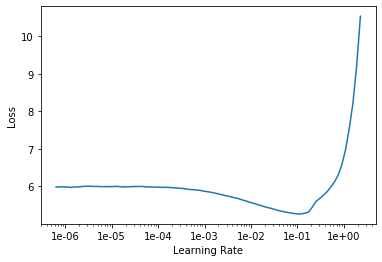

In [33]:
learn.recorder.plot()

In [34]:
learn.freeze()

In [35]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.576837,4.169918,0.375186,00:08


In [51]:
learn.unfreeze()

In [36]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.938181,4.110249,0.384003,00:08
1,3.838890,4.084957,0.388095,00:08


In [37]:
learn.predict('ರಾಮ್',n_words=10)

'ರಾಮ್ ▁ಗೆ ರಾಧ ▁ಸರಣಿ : ▁ಹೊಸ ? ? ▁x x b'

In [38]:
learn.save_encoder('fine_tuned_enc')

In [39]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=kannada_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [40]:
data_clas.show_batch()

text,target
▁x x b os ▁ y a <unk> am ana <unk> vi e ▁bo x <unk> <unk> ff ice <unk> ▁c oll ection s : ▁ಬಾ ಕ್ಸಾ ಫಿ ಸ್ ▁ನಲ್ಲಿ ▁ಧೂಳ ೆ ಬ್ಬ ಿಸುತ್ತಿರುವ ▁ಡಿ - ಬಾ ಸ್ ▁: ▁ಮೂರು ▁ದಿನಗಳಲ್ಲಿ ▁' ಯ ಜ ಮಾನ ' ನ ▁ಗಳಿಕೆ ▁ಎಷ್ಟು ▁ಗೊತ್ತ ಾ . . ?,entertainment
▁x x b os <unk> <unk> d g har s ha ▁tr ai ler : ▁ ಸಸ್ ಪೆನ್ ಸ್ ▁ಮಾಸ್ಟರ್ ▁ಸು ನೀ ಲ್ ▁ಕುಮಾರ್ ▁ದೇಸಾಯಿ ▁ಇಸ್ ▁ಬ್ಯಾಕ್ ▁: ▁' ಉದ್ ಘರ್ ಷ ' ▁ಟ್ರೈ ಲರ್ ▁ನಲ್ಲಿ ▁ಕಿ ಚ್ಚ ▁ಸು ದೀಪ್ ▁ಇಂಗ್ಲಿಷ್ ▁ಹೇಗ ಿದೆ ▁ಗೊತ್ತ ಾ . . ?,entertainment
▁x x b os <unk> <unk> l ▁v s <unk> ▁l ok <unk> ▁s ab ha ▁ elect ions : ▁ಐಪಿಎಲ್ - ಲೋಕ ಸಭೆ ▁ಅಂತಿಮ ▁ಹಣ ಾಹ ಣಿ ▁ಕ್ಲ ್ಯಾ ಶ್ ▁! ; ▁ಬಿಸಿ ಸಿ ಐ ▁ನಿರ್ಧಾರ ವೇ ನು ▁ಗೊತ್ತ ಾ ?,sports
▁x x b os <unk> ▁p ul w ama <unk> ▁a ttack : ▁ಯೂಟ್ಯೂಬ್ ▁ಚಾನಲ್ ▁ನಿಂದ ▁ಆ ತಿ ಫ್ ▁ಅಸ್ ಲಂ - ರಾ ಹ ತ್ ▁ಫತೇ ▁ಅಲಿ ಖಾನ್ ▁ರ ▁ಹಾಡುಗಳನ್ನು ತೆಗೆ ದು ▁ಹಾಕಿದ ▁ಟಿ - ಸೀ ರೀಸ್ ▁ . . !,entertainment
"▁x x b os <unk> ▁v s ▁new ▁ <unk> ea land , <unk> ▁l ive <unk> ▁c r ick et <unk> ▁s c ore : ▁ಕಿ ವೀ ಸ್ ▁ನಾಡ ಲ್ಲಿ ▁ಭಾರತ ▁ಶುಭ ಾರಂಭ : ▁8 ▁ವಿಕೆಟ್ ▁ಗಳ ▁ಭರ್ಜರಿ ▁ಜಯ",sports


In [41]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [42]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [43]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5167 items)
x: TextList
▁x x b os <unk> ▁c w g 18 ; ▁ಕುಸ್ತಿ ಯಲ್ಲಿ ▁ಚಿನ್ನ ಗಳ ಿಸಿದ ▁ರಾಹುಲ್ ▁ಅವ ಾರೆ , ▁ಸುಶೀಲ ್ ▁ಕುಮಾರ್,▁x x b os ▁ಏಷ್ಯಾ ▁ಕಪ್ ▁2018 : ▁ಪಾ ಕ್ ▁ವಿರುದ್ಧ ▁ಘ ರ್ಜಿ ಸಲು ▁ರೋಹಿತ ್ ▁ಸೈನ್ಯ ▁ಹೇಗ ಿದೆ . . ?,▁x x b os ▁ಸಮ ಂತಾ ▁ವಿಷಯದಲ್ಲಿ ▁' ಯೂ ▁ಟರ್ ನ್ ' ▁ಹೊಡೆದ ▁ನಾಗ ▁ಚೈತನ್ಯ . . !,▁x x b os <unk> ▁p h o <unk> to s : ▁ಐ ಶ್ ▁ಬೇಬಿ ▁ಸೌಂದರ್ಯ ದ ▁ಗು ಟ್ಟು ▁ರ ಟ್ಟು : ▁40 ▁ದಾಟಿದ ರೂ ▁ಹಾಟ್ ▁ಲುಕ್ ಕ ಿಗೇ ನು ▁ಕಡಿಮೆ ▁ಇಲ್ಲ,▁x x b os ▁ಟೀ ಂ ▁ಇಂಡಿಯಾ ▁ಆಯ್ಕೆ ▁ಸಮಿತಿ ▁ಸದಸ್ಯರ ▁ಸಂಭಾವನೆ ▁ಎಷ್ಟು ▁ಗೊತ್ತ ಾ . . ?
y: CategoryList
sports,sports,entertainment,entertainment,sports
Path: /home/gaurav/PycharmProjects/nlp-for-kannada/classification;

Valid: LabelList (1293 items)
x: TextList
▁x x b os ▁ಬಜಾರ್ ▁ಅಂಗಳ ದಲ್ಲಿ ▁ಸಿಕ್ಕ ▁ಧನ ್ ವೀರ್,▁x x b os ▁ಬಿಡುಗಡೆಯಾಯಿತು ▁ಕಿ ಚ್ಚ ▁ಸು ದೀಪ್ ▁ಕಂಠ ದಾನ ▁ಮಾಡಿರುವ ▁ಸಿನಿಮಾ ದ ▁ಟ್ರೇ ಲರ್ ▁ . . !,▁x x b os ▁ಸ್ಮಿತ್ , ▁ವಾರ್ನರ್ ▁ , ▁ಬ್ಯಾಂಕ್ ರಾ ಫ್ಟ್ ▁ಗೆ ▁ಶಿಕ್ಷೆ ▁ಕಡಿತ ವಿಲ್ಲ ▁ಎಂದ ▁ಬೋರ್ಡ್,▁x x b os ▁ಬೆಂಗಳೂರು ▁ಅಂತರ ▁ರಾಷ್ಟ್ರೀಯ ▁ಚಲನಚಿತ್ರೋತ್ಸವ ದಲ್ಲಿ ▁ಏಷ್ಯನ್ ▁ಸಿನ

In [44]:
learn.freeze()

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


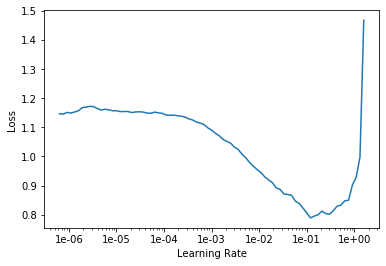

In [46]:
learn.recorder.plot()

In [47]:
learn.loss_func.func

CrossEntropyLoss()

In [48]:
kappa = KappaScore()

In [49]:
learn.metrics = [kappa, accuracy]

In [50]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.398411,0.250452,0.856710,0.915700,00:06


In [51]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.324954,0.168237,0.899499,0.941222,00:07


In [52]:
learn.save('second-full')

In [53]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.221969,0.151396,0.913182,0.948956,00:11
1,0.133729,0.140351,0.919609,0.952823,00:12
2,0.102456,0.161830,0.916922,0.951276,00:11
3,0.078728,0.158081,0.924920,0.955916,00:12
4,0.042520,0.160484,0.930436,0.959010,00:12


Better model found at epoch 0 with accuracy value: 0.9489558935165405.
Better model found at epoch 1 with accuracy value: 0.9528228640556335.
Better model found at epoch 3 with accuracy value: 0.9559164643287659.
Better model found at epoch 4 with accuracy value: 0.9590100646018982.


In [54]:
learn.predict('ಬಾಲಿವುಡ್ ಸ್ಟಾರ್ ನಟನ ಸಿನಿಮಾದಲ್ಲಿ ಸೌತ್ ಸುಂದರಿ ಕೀರ್ತಿ ಸುರೇಶ್')

(Category entertainment,
 tensor(0),
 tensor([9.9763e-01, 1.9658e-03, 3.9923e-04]))

In [55]:
learn.predict("ಚಿತ್ರರಂಗದಿಂದ ಯಾರ್ ಯಾರು ಬರ್ತಾರಂತಾ ಮಾರ್ಚ್ 18ಕ್ಕೆ ನೋಡಿ")

(Category entertainment, tensor(0), tensor([0.9966, 0.0016, 0.0018]))

In [56]:
learn.predict("ಮತದಾನದ ಅರಿವು ಮೂಡಿಸುವಂತೆ ಸಿನಿತಾರೆಯರಿಗೆ ಪ್ರಧಾನಿ ಮೋದಿ ಕರೆ")

(Category entertainment, tensor(0), tensor([0.9914, 0.0030, 0.0056]))

In [57]:
learn.predict("ಸಿದ್ಧರಾಗಿರಿ ಬರ್ತಾ ಇದೆ 'ಬೆಲ್ ಬಾಟಂ ಪಾರ್ಟ್ -2'")

(Category entertainment, tensor(0), tensor([0.9225, 0.0048, 0.0726]))